## Tasks

In [5]:
import os
import time
import sys

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/%autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
pd.options.display.max_columns = None  # display all columns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
rt = '/Users/geekduck/Dropbox/gt_survey'
os.environ['project_root'] = rt
sys.path.append(os.environ['project_root'])

import carpoolsim.network_prepare as network_prepare
import carpoolsim.carpool as carpool

## Load GT survey data (processed)

In [4]:
gt_survey = pd.read_csv(
    os.path.join(
        os.getcwd(),
        "data_outputs",
        "step1_gt_survey",
        "gt_survey.csv"
    ),
    index_col=0
)
print(gt_survey.shape)

(1519, 153)


In [5]:
gt_survey.sample(5)

,StartDate,EndDate,Status,Progress,Duration..in.seconds.,Finished,RecordedDate,ResponseId,DistributionChannel,UserLanguage,Q66,Q73,Q73_2_TEXT,Q73_5_TEXT,Q2,Q68,Q67,Q3,Q3_6_TEXT,Q5,Q45,ZIPCODE,Q56_1,Q56_2,Q56_3,Q56_4,Q56_5,Q10,Q11,Q12_1,Q12_2,Q12_3,Q12_4,Q12_5,Q12_6,Q12_7,Q12_8,Q12_9,Q12_10,Q12_11,Q12_12,Q12_13,Q12_18,Q12_14,Q12_15,Q12_16,Q12_17,Q12_17_TEXT,Q13_1,Q13_2,Q13_3,Q13_1_TEXT,Q13_2_TEXT,Q13_3_TEXT,Q14_1,Q14_2,Q14_3,Q14_1_TEXT,Q14_2_TEXT,Q14_3_TEXT,Q15,Q16,Q16_3_TEXT,Q69,Q69_6_TEXT,Q17,Q18,Q19,Q55,Q20_1,Q20_2,Q20_3,Q20_4,Q20_5,Q20_6,Q20_7,Q20_8,Q20_9,Q20_10,Q20_11,Q20_13,Q20_14,Q20_16,Q20_17,Q20_18,Q20_19,Q20_20,Q20_21,Q20_22,Q20_22_TEXT,Q25,Q25_14_TEXT,Q64,Q26,Q26_16_TEXT,Q27,Q28,Q29,Q30_1,Q30_2,Q30_3,Q30_4,Q30_5,Q30_6,Q30_7,Q30_8,Q30_12,Q30_10,Q30_11,Q32_1,Q32_2,Q32_3,Q32_4,Q32_5,Q34_1,Q34_2,Q34_3,Q34_4,Q34_5,Q34_6,Q34_7,Q34_8,Q34_9,Q34_10,Q34_11,Q34_12,Q34_13,Q34_14,Q34_15,Q34_16,Q47,Q59,Q51,Q49,Q49_5_TEXT,Q48,Q50,Q61,Q62,Q65,Q35,Q38,depart_time,newmin,ori_lon,ori_lat,geometry,orig_taz,dest_taz,dest_lon,dest_lat,O_region,D_region
139,10/31/2022 15:46,10/31/2022 15:53,IP Address,100,418,True,10/31/2022 15:53,R_33cYWv2Scy5etOI,email,EN,No,NaN,NaN,NaN,I live off campus and work or attend class at ...,NaN,NaN,Faculty member,NaN,1 hour or more,more than 30 miles,30116,"Drive alone (car, truck, motorcycle, moped)","Drive alone (car, truck, motorcycle, moped)","Drive alone (car, truck, motorcycle, moped)",NaN,NaN,7:30am,4:30pm,Don't have anyone to ride/carpool with,NaN,NaN,Enjoy the ride/prefer to drive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Transit takes too long,NaN,NaN,NaN,NaN,Anything else takes too much time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,Ability to telecommute,NaN,NaN,"Expanded regional transit options (MARTA, ligh...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Vanpool program,NaN,NaN,NaN,MARTA rail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Yes, but I have NOT used this program","No, I am not aware of this program","No, I am not aware of this program","Yes, but I have NOT used this program","No, I am not aware of this program","No, I am not aware of this program","Yes, but I have NOT used this program","Yes, but I have NOT used this program","Yes, but I have NOT used this program","Yes, but I have NOT used this program","Yes, but I have NOT used this program","Yes, but I have NOT used this program","No, I am not aware of this program","No, I am not aware of this program","No, I am not aware of this program","No, I am not aware of this program",more than $200,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,2023-01-01 07:30:00,450.0,-85.0499,33.6045,POINT (-85.0499 33.6045),5072,484,-84.397971,33.775766,8_1,3_1
1053,11/3/2022 13:20,11/3/2022 13:29,IP Address,100,570,True,11/3/2022 13:29,R_2ZZxb51QqjShPwP,email,EN,Yes,Mostly use the TransLoc app,NaN,NaN,I live off campus and work or attend class at ...,NaN,NaN,Faculty member,NaN,40-59 minutes,21 to 30 miles,30350,"Drive alone (car, truck, motorcycle, moped)","Drive alone (car, truck, motorcycle, moped)","Drive alone (car, truck, motorcycle, moped)","Drive alone (car, truck, motorcycle, moped)","Drive alone (car, truck, motorcycle, moped)",8:30am,6:00pm,NaN,NaN,"Drop off children (childcare, school, after sc...",Enjoy the ride/prefer to drive,NaN,NaN,NaN,Need my car at work for personal business,Need to leave quickly in an emergency,NaN,NaN,NaN,NaN,NaN,NaN,Safety concerns,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,Ability to telecommute,NaN,NaN,NaN,NaN,NaN,Flexible work schedule,NaN,NaN,NaN,NaN,Need to save money,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MARTA rail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Yes, but I have NOT used this program","Yes, but I have NOT used this program","Yes, but I have NOT used this program","Yes, but I have NOT used this program","No, I am n

## Prepare CarpoolSim Network

In [6]:
# load original links and nodes (containing all connector and centriods, which construct a whole network)
file_name_nodes = os.path.join(
    "data_inputs",
    'ABM2020 203K', 
    '2020 nodes with latlon',
    '2020_nodes_latlon.shp'
)
file_name_links = os.path.join(
    "data_inputs",
    'ABM2020 203K',
    '2020 links',
    '2020_links.shp'
)

df_nodes_raw = gpd.read_file(
    os.path.join(os.environ['project_root'], file_name_nodes)
)
df_links_raw = gpd.read_file(
    os.path.join(os.environ['project_root'], file_name_links)
)

In [10]:
print('** Initialize RoadwaySim network **')
df_links = network_prepare.initialize_abm15_links(drop_connector=False)
df_links.head(2)

** Initialize RoadwaySim network **


,A,B,A_B,geometry,SPEED_LIMI,DISTANCE,NAME,FACTYPE,Ax,Ay,A_lat,A_lon,Bx,By,B_lat,B_lon,minx_sq,miny_sq,maxx_sq,maxy_sq
0,1,65666,1_65666,"LINESTRING (2220978.672 1483122.486, 2221582.3...",35,0.23355,None,0,2.220979e+06,1.483122e+06,34.076861,-84.416355,2.221582e+06,1.484198e+06,34.07982,-84.41437,89.0,59.0,89.0,59.0
1,1,80483,1_80483,"LINESTRING (2220978.672 1483122.486, 2220402.3...",35,0.44684,None,0,2.220979e+06,1.483122e+06,34.076861,-84.416355,2.220402e+06,1.480835e+06,34.07057,-84.41824,89.0,59.0,89.0,59.0


In [11]:
# build networkx graph takes less than two minutes
print('** build RoadwaySim network **')
# use default speed 45 mph
dict_network = {
    'DG': network_prepare.build_carpool_network(df_links),
    'links': df_links
}

** build RoadwaySim network **


In [12]:
# combine all settings
print('** setup meta-information **')
dict_settings = {
    'walk_speed': 30,  # the travelling speed from origin/destination to nearest network, 30mph
    'grid_size': 25000.0,  # for searching nearby links by grouping links to grids with width 25000 ft. for efficiency in searching
    'ntp_dist_thresh': 5280.0,  # node to point (maximum distance access to network from origin/destination); (walking) distance threshold
    'network': {'bike': dict_network},  # dump in networks and modes
    'walk_thresh': {'bike': 1},  # traveling threshold is 1 mile
}

** setup meta-information **


## Matched to origins/destinations

In [13]:
df_nodes_raw.head()

,N,X,Y,STATION,STAFLAG,PNR,PNR_MAJOR,GEOMETRYSO,lat,lon,geometry
0,1,2.220979e+06,1.483122e+06,None,0,0,0,1,34.076861,-84.416355,POINT (-84.41636 34.07686)
1,2,2.222861e+06,1.479567e+06,None,0,0,0,1,34.067103,-84.410110,POINT (-84.41011 34.06710)
2,3,2.226472e+06,1.484525e+06,None,0,0,0,1,34.080752,-84.398224,POINT (-84.39822 34.08075)
3,4,2.233517e+06,1.483418e+06,None,0,0,0,1,34.077750,-84.374950,POINT (-84.37495 34.07775)
4,5,2.236754e+06,1.485119e+06,None,0,0,0,1,34.082443,-84.364269,POINT (-84.36427 34.08244)


In [14]:
df_nodes_raw["N"] = df_nodes_raw["N"].astype(str)

In [15]:
# match origin/destination to nearest nodes!
def get_orig_xy(df_row, df_nodes):
    filt = (df_nodes.N == str(df_row["orig_taz"]))
    X = df_nodes.loc[filt, "X"].iloc[0]
    Y = df_nodes.loc[filt, "Y"].iloc[0]
    node = df_nodes.loc[filt, "N"].iloc[0]
    return pd.Series({
        "ox": X,
        "oy": Y,
        "o_node": str(node)
    })

def get_dest_xy(df_row, df_nodes):
    filt = (df_nodes.N == str(df_row["dest_taz"]))
    X = df_nodes.loc[filt, "X"].iloc[0]
    Y = df_nodes.loc[filt, "Y"].iloc[0]
    node = df_nodes.loc[filt, "N"].iloc[0]
    return pd.Series({
        "dx": X,
        "dy": Y,
        "d_node": str(int(node))
    })

gt_survey[["ox", "oy", "o_node"]] = gt_survey.apply(
    get_orig_xy, axis=1,
    df_nodes = df_nodes_raw
)
gt_survey[["dx", "dy", "d_node"]] = gt_survey.apply(
    get_dest_xy, axis=1,
    df_nodes = df_nodes_raw
)
gt_survey.head()

,StartDate,EndDate,Status,Progress,Duration..in.seconds.,Finished,RecordedDate,ResponseId,DistributionChannel,UserLanguage,Q66,Q73,Q73_2_TEXT,Q73_5_TEXT,Q2,Q68,Q67,Q3,Q3_6_TEXT,Q5,Q45,ZIPCODE,Q56_1,Q56_2,Q56_3,Q56_4,Q56_5,Q10,Q11,Q12_1,Q12_2,Q12_3,Q12_4,Q12_5,Q12_6,Q12_7,Q12_8,Q12_9,Q12_10,Q12_11,Q12_12,Q12_13,Q12_18,Q12_14,Q12_15,Q12_16,Q12_17,Q12_17_TEXT,Q13_1,Q13_2,Q13_3,Q13_1_TEXT,Q13_2_TEXT,Q13_3_TEXT,Q14_1,Q14_2,Q14_3,Q14_1_TEXT,Q14_2_TEXT,Q14_3_TEXT,Q15,Q16,Q16_3_TEXT,Q69,Q69_6_TEXT,Q17,Q18,Q19,Q55,Q20_1,Q20_2,Q20_3,Q20_4,Q20_5,Q20_6,Q20_7,Q20_8,Q20_9,Q20_10,Q20_11,Q20_13,Q20_14,Q20_16,Q20_17,Q20_18,Q20_19,Q20_20,Q20_21,Q20_22,Q20_22_TEXT,Q25,Q25_14_TEXT,Q64,Q26,Q26_16_TEXT,Q27,Q28,Q29,Q30_1,Q30_2,Q30_3,Q30_4,Q30_5,Q30_6,Q30_7,Q30_8,Q30_12,Q30_10,Q30_11,Q32_1,Q32_2,Q32_3,Q32_4,Q32_5,Q34_1,Q34_2,Q34_3,Q34_4,Q34_5,Q34_6,Q34_7,Q34_8,Q34_9,Q34_10,Q34_11,Q34_12,Q34_13,Q34_14,Q34_15,Q34_16,Q47,Q59,Q51,Q49,Q49_5_TEXT,Q48,Q50,Q61,Q62,Q65,Q35,Q38,depart_time,newmin,ori_lon,ori_lat,geometry,orig_taz,dest_taz,dest_lon,dest_lat,O_region,D_region,ox,oy,o_node,dx,dy,d_node
4,10/31/2022 14:28,10/31/2022 14:36,IP Address,100,454,True,10/31/2022 14:36,R_3I6RkopoEqc7Hhp,email,EN,Yes,Mostly use the TransLoc app,NaN,NaN,I live off campus and work or attend class at ...,NaN,NaN,Staff member,NaN,20-39 minutes,4 to 10 miles,30344,Telecommute (work from home),Telecommute (work from home),"Drive alone (car, truck, motorcycle, moped)","Drive alone (car, truck, motorcycle, moped)","Drive alone (car, truck, motorcycle, moped)",7:30am,5:00pm,NaN,Don't like to depend on others for carpooling,NaN,Enjoy the ride/prefer to drive,NaN,NaN,NaN,NaN,Need to leave quickly in an emergency,NaN,NaN,NaN,NaN,NaN,NaN,Safety concerns,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Need to save money,NaN,NaN,NaN,NaN,NaN,NaN,Nothing would alter my current driving habits,NaN,NaN,MARTA bus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Yes, but I have NOT used this program","No, I am not aware of this program","No, I am not aware of this program","No, I am not aware of this program","No, I am not aware of this program","No, I am not aware of this program","No, I am not aware of this program","No, I am not aware of this program","Yes, but I have NOT used this program","Yes, but I have NOT used this program","Yes, but I have NOT used this program","No, I am not aware of this program","No, I am not aware of this program","No, I am not aware of this program","No, I am not aware of this program","No, I am not aware of this program",$50 to $100,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,2023-01-01 07:30:00,450.0,-84.4480,33.6919,POINT (-84.448 33.6919),1087,484,-84.397971,33.775766,3_4,3_1,2.213375e+06,1.343762e+06,1087,2.226575e+06,1.373267e+06,484
5,10/31/2022 14:31,10/31/2022 14:36,IP Address,100,263,True,10/31/2022 14:36,R_Olq3a5qleDd1xBv,email,EN,No,NaN,NaN,NaN,I live off campus and work or attend class at ...,NaN,NaN,Faculty member,NaN,40-59 minutes,4 to 10 miles,30310,MARTA rail,MARTA rail,MARTA rail,MARTA rail,Did not work/flexible schedue,7:30am,6:00pm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,West End,Midtown station,NaN,Walk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Yes, but I have NOT used this program","No, I am not aware of this program","No, I am not aware of this program","Yes, and I have used this program","No, I am not aware of this program","No, I am not aware of this program","Yes, and I have used this program","Yes, and I have used this program","No, I am not aware of this program","Yes, but I have NOT used this program","Yes, but I have NOT used this program","Yes, and I have used t

## Prepare DataFrame of parking lots

In [16]:
parking_lots = gpd.read_file(
    os.path.join(
        "data_inputs",
        "Park_and_Ride_locations",
        "Park_and_Ride_locations.shp"
    )
)
print(parking_lots.shape)
parking_lots.head()

(106, 10)


,OBJECTID,NAME,CITY,SPACES,GlobalID,StreetNumb,PostalCode,StreetName,Publish,geometry
0,76,MARTA - INDIAN CREEK STATION,Stone Mountain,2350,{46FF823F-E6E7-4597-B5B7-3BEC503B47A8},3901,30083,Durham Park Road,Yes,POINT (-84.22903 33.76839)
1,78,Hewatt Road park & ride,Snellville,125,{CCDA4DB1-A240-4013-A8F9-23741EAD99FF},2191,30039,Hewatt Rd,Yes,POINT (-84.05962 33.83902)
2,79,POST RD,Winston,0,{CFDBFBE5-E50A-425C-A24F-90083AA7C746},3014,30187,Post Rd,Yes,POINT (-84.82816 33.72269)
3,80,VIENNA,Vienna,32,{3D451501-D563-45A3-8A4B-CE740FF5C3F9},None,31092,W Union St & 1st St,Yes,POINT (-83.79881 32.09203)
4,81,Acworth Park & Ride,Acworth,0,{E7136D07-6D1B-42D3-A161-3CBC5BD6FEC6},6045,30101,Lake Acworth Dr,Yes,POINT (-84.65642 34.07754)


In [17]:
parking_lots = gpd.GeoDataFrame(
    parking_lots,
    geometry=parking_lots["geometry"]
)

parking_lots['taz'] = None

In [18]:
from shapely.geometry import Polygon, LineString, Point
# finally, add a column for TAZ, delete useless columns
user_name = "/Users/geekduck/"
taz_df = gpd.read_file(
    os.path.join(
        os.environ["project_root"],
        "data_inputs",
        "ABM2020 203K",
        "taz",
        "TAZ_combine.shp"
    )
)

# for each point, search if it is contained in polygon
s = taz_df['geometry']
def get_taz(x):
    filt = taz_df.contains(x)
    if sum(filt) > 0:
        taz = taz_df.loc[filt, 'TAZS'].iloc[0]
    else:
        taz = -1
    return taz

parking_lots['taz'] = parking_lots['geometry'].apply(get_taz)
parking_lots.head()

,OBJECTID,NAME,CITY,SPACES,GlobalID,StreetNumb,PostalCode,StreetName,Publish,geometry,taz
0,76,MARTA - INDIAN CREEK STATION,Stone Mountain,2350,{46FF823F-E6E7-4597-B5B7-3BEC503B47A8},3901,30083,Durham Park Road,Yes,POINT (-84.22903 33.76839),1762
1,78,Hewatt Road park & ride,Snellville,125,{CCDA4DB1-A240-4013-A8F9-23741EAD99FF},2191,30039,Hewatt Rd,Yes,POINT (-84.05962 33.83902),2642
2,79,POST RD,Winston,0,{CFDBFBE5-E50A-425C-A24F-90083AA7C746},3014,30187,Post Rd,Yes,POINT (-84.82816 33.72269),3849
3,80,VIENNA,Vienna,32,{3D451501-D563-45A3-8A4B-CE740FF5C3F9},None,31092,W Union St & 1st St,Yes,POINT (-83.79881 32.09203),-1
4,81,Acworth Park & Ride,Acworth,0,{E7136D07-6D1B-42D3-A161-3CBC5BD6FEC6},6045,30101,Lake Acworth Dr,Yes,POINT (-84.65642 34.07754),1946


In [19]:
filt = (parking_lots.taz != -1)
parking_lots = parking_lots.loc[filt, :].copy()
print(parking_lots.shape)

(73, 11)


In [20]:
# get lon, lat
parking_lots['lon'] = parking_lots.geometry.x
parking_lots['lat'] = parking_lots.geometry.y

In [21]:
pth = 'data_outputs/step2_parking_lots/Atlanta_parkinglots.csv'
parking_lots.to_csv(pth, index=False)

parking_lots = network_prepare.pnr_pre_process(pth, dict_settings)
display(parking_lots.head())

73 points to prepare


,OBJECTID,NAME,CITY,SPACES,GlobalID,StreetNumb,PostalCode,StreetName,Publish,geometry,taz,lon,lat,x,y,x_sq,y_sq,node,t,d
0,76,MARTA - INDIAN CREEK STATION,Stone Mountain,2350,{46FF823F-E6E7-4597-B5B7-3BEC503B47A8},3901,30083,Durham Park Road,Yes,POINT (2277632.462 1370791.775),1762,-84.229027,33.768392,2.277632e+06,1.370792e+06,91.0,55.0,18088,0.003512,0.105346
1,78,Hewatt Road park & ride,Snellville,125,{CCDA4DB1-A240-4013-A8F9-23741EAD99FF},2191,30039,Hewatt Rd,Yes,POINT (2329085.579 1396501.335),2642,-84.059625,33.839017,2.329086e+06,1.396501e+06,93.0,56.0,11092,0.006979,0.209379
2,79,POST RD,Winston,0,{CFDBFBE5-E50A-425C-A24F-90083AA7C746},3014,30187,Post Rd,Yes,POINT (2095453.308 1354800.231),3849,-84.828164,33.722687,2.095453e+06,1.354800e+06,84.0,54.0,25177,0.001543,0.046278
3,81,Acworth Park & Ride,Acworth,0,{E7136D07-6D1B-42D3-A161-3CBC5BD6FEC6},6045,30101,Lake Acworth Dr,Yes,POINT (2148288.170 1483633.984),1946,-84.656422,34.077543,2.148288e+06,1.483634e+06,86.0,59.0,82556,0.002236,0.067093
4,82,MARTA - EAST LAKE STATION,Atlanta,611,{F10439E9-BE20-46B8-BB44-C3B3E854E046},2260,30307,College Avenue,Yes,POINT (2252127.592 1369350.452),1648,-84.312949,33.764360,2.252128e+06,1.369350e+06,90.0,55.0,15298,0.001316,0.039488


## Connect to database with shortest paths

In [22]:
# connect to postgresql database for fast query of shortest traveling path
# 'sqlite:///build_graph/path_retention.db'
db_full_path = "sqlite:////Users/geekduck/Dropbox/gt_survey/data_inputs/path_retention.db"
engine = create_engine(db_full_path)

In [23]:
from carpoolsim.database.query_database import (
    query_od_info, 
    execute_sql_command
)

In [24]:
# query OD information between "1" and "2"
query_od_info(engine, '1', '2')

('1', '2', 1.6642285714285716, ['1', '80483', '2'])

## mode 0: direct carpool

In [25]:
from carpoolsim.carpool.trip_cluster import TripCluster
from carpoolsim.carpool.trip_cluster_with_time import TripClusterWithTime

In [27]:
t0 = time.perf_counter()
tc = TripClusterWithTime(
    gt_survey, 
    dict_network['DG'], dict_network['links'], engine,
    delta_t=100, epsilon_t=20,
    parking_lots=parking_lots
)

kwargs = {
    # use bipartite method. If not, may try to use linear optimization
    'rt_bipartite': True,
    # setup print options
    'verbose': False, 'print_mat': False, 'plot_all': True,
    # coordinate filters
    'mu1': 1.5, 'mu2': 0.1, 'dst_max': 5*5280,
    # reroute filters
    'delta': 10, 'gamma': 1.3, 'ita': 0.9, 'ita_pnr': 0.5,  # reroute filters
    # Delta1: control passenger/driver's departure time difference
    # Delta2: control driver's maximum waiting time
    'Delta1': 15, 'Delta2': 10, 'Gamma': 0.2,
    # carpool mode
    'mode':0
}

summ_stats1, summ_stats_ind1 = tc.run_all_sim(kwargs = kwargs)
display(summ_stats1)
t_diff = time.perf_counter() - t0
print("Time is takes is {} seconds".format(t_diff))

Finished running all simulation in 29.09 minutes for a trip cluster with 1519.0 trips!


,tot_num,paired_num,orig_tt,opti_tt,orig_ml,opti_ml
0,1519.0,996.0,17126.348192,8066.569406,16796.86223,8117.244612


Time is takes is 1745.7391831669956 seconds


<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

In [109]:
# print direct carpool
print(sum((summ_stats_ind1.SOV==False)))
# print SOV
print(sum((summ_stats_ind1.SOV==True)))

996
523


In [110]:
996 / (996+523)

0.6556945358788677

### mode 2: PNR carpool

In [29]:
t0 = time.perf_counter()
tc = TripClusterWithTime(
    gt_survey,
    dict_network['DG'], dict_network['links'], engine,
    delta_t=60, epsilon_t=20,
    parking_lots=parking_lots
)

kwargs = {
    'rt_bipartite': True,
    'verbose': False, 'print_mat': False, 'plot_all': True,
    'mu1': 1.5, 'mu2': 0.1, 'dst_max': 5*5280,  # coordinate filters
    'delta': 10, 'gamma': 1.3, 'ita': 0.9, 'ita_pnr': 0.5,  # reroute filters
    'Delta1': 15, 'Delta2': 10, 'Gamma': 0.2,
    'mode':1
}

summ_stats2, summ_stats_ind2 = tc.run_all_sim(kwargs = kwargs)
display(summ_stats2)
t_diff = time.perf_counter() - t0
print("Time is takes is {} seconds".format(t_diff))

Finished running all simulation in 22.22 minutes for a trip cluster with 1519.0 trips!


,tot_num,paired_num,orig_tt,opti_tt,orig_ml,opti_ml
0,1519.0,212.0,17126.348192,15367.081437,16796.86223,14941.398999


Time is takes is 1333.0824882920133 seconds


<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

In [30]:
summ_stats2

,tot_num,paired_num,orig_tt,opti_tt,orig_ml,opti_ml
0,1519.0,212.0,17126.348192,15367.081437,16796.86223,14941.398999


In [31]:
# print direct carpool
print(sum((summ_stats_ind2.station==-1) & (summ_stats_ind2.SOV==False)))
# print pnr carpool
print(sum(summ_stats_ind2.station>=0))
# print SOV
print(sum((summ_stats_ind2.SOV==True)))

0
212
1307


In [32]:
212 / (1307+212)

0.13956550362080317

### mode 3: Direct Carpool + PNR Carpool

In [33]:
t0 = time.perf_counter()
tc = TripClusterWithTime(
    gt_survey,
    dict_network['DG'], dict_network['links'], engine,
    delta_t=60, epsilon_t=20,
    parking_lots=parking_lots
)

kwargs = {
    'rt_bipartite': True,
    'verbose': False, 'print_mat': False, 'plot_all': True,
    'mu1': 1.5, 'mu2': 0.1, 'dst_max': 5*5280,  # coordinate filters
    'delta': 10, 'gamma': 1.3, 'ita': 0.9, 'ita_pnr': 0.5,  # reroute filters
    'Delta1': 15, 'Delta2': 10, 'Gamma': 0.2,
    'mode':2
}

summ_stats3, summ_stats_ind3 = tc.run_all_sim(kwargs = kwargs)
display(summ_stats3)
t_diff = time.perf_counter() - t0
print("Time is takes is {} seconds".format(t_diff))

Finished running all simulation in 43.14 minutes for a trip cluster with 1519.0 trips!


,tot_num,paired_num,orig_tt,opti_tt,orig_ml,opti_ml
0,1519.0,1042.0,17126.348192,7677.12417,16796.86223,7683.473576


Time is takes is 2588.4916144169983 seconds


<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

In [34]:
summ_stats3

,tot_num,paired_num,orig_tt,opti_tt,orig_ml,opti_ml
0,1519.0,1042.0,17126.348192,7677.12417,16796.86223,7683.473576


In [35]:
summ_stats_ind3

,newmin,before_time,before_dist,after_time,after_dist,SOV,as_passenger,partner_idx,station
2001,330.0,4.594,3.573,4.594000,3.573000,False,True,1512,-1
1512,330.0,4.594,3.573,4.594000,3.573000,False,False,2001,-1
864,330.0,4.594,3.573,4.594000,3.573000,True,False,864,-1
365,330.0,25.137,28.239,25.136999,28.239000,True,False,365,-1
1476,330.0,23.454,25.188,23.454000,25.188000,False,True,1965,22
...,...,...,...,...,...,...,...,...,...
2404,1290.0,6.084,5.580,6.084000,5.580000,True,False,2404,-1
1115,1290.0,17.923,18.001,17.923000,18.000999,True,False,1115,-1
60,1290.0,27.518,30.654,27.518000,30.654000,False,True,2002,16
2002,1290.0,27.812,28.530,34.844002,36.381001,False,False,60,16


In [36]:
# print direct carpool
print(sum((summ_stats_ind3.station==-1) & (summ_stats_ind3.SOV==False)))
# print pnr carpool
print(sum(summ_stats_ind3.station>=0))
# print SOV
print(sum((summ_stats_ind3.SOV==True)))

992
50
477


In [37]:
(992 + 50) / (477 + 992 + 50)

0.6859776168531929

In [57]:
# store results
summ_stats_ind1.to_csv(
    "data_outputs/step2_results/summ_stats_mode0.csv"
)
summ_stats_ind2.to_csv(
    "data_outputs/step2_results/summ_stats_mode1.csv"
)
summ_stats_ind3.to_csv(
    "data_outputs/step2_results/summ_stats_mode2.csv"
)

# store gt survey results
gt_survey.to_csv(
    "data_outputs/step2_gt_survey/gt_survey_commute.csv"
)

## map distribution over space

In [78]:
gdf = gpd.GeoDataFrame(
    gt_survey, 
    geometry=gt_survey["geometry"]
)


In [79]:
gdf.head()

,StartDate,EndDate,Status,Progress,Duration..in.seconds.,Finished,RecordedDate,ResponseId,DistributionChannel,UserLanguage,Q66,Q73,Q73_2_TEXT,Q73_5_TEXT,Q2,Q68,Q67,Q3,Q3_6_TEXT,Q5,Q45,ZIPCODE,Q56_1,Q56_2,Q56_3,Q56_4,Q56_5,Q10,Q11,Q12_1,Q12_2,Q12_3,Q12_4,Q12_5,Q12_6,Q12_7,Q12_8,Q12_9,Q12_10,Q12_11,Q12_12,Q12_13,Q12_18,Q12_14,Q12_15,Q12_16,Q12_17,Q12_17_TEXT,Q13_1,Q13_2,Q13_3,Q13_1_TEXT,Q13_2_TEXT,Q13_3_TEXT,Q14_1,Q14_2,Q14_3,Q14_1_TEXT,Q14_2_TEXT,Q14_3_TEXT,Q15,Q16,Q16_3_TEXT,Q69,Q69_6_TEXT,Q17,Q18,Q19,Q55,Q20_1,Q20_2,Q20_3,Q20_4,Q20_5,Q20_6,Q20_7,Q20_8,Q20_9,Q20_10,Q20_11,Q20_13,Q20_14,Q20_16,Q20_17,Q20_18,Q20_19,Q20_20,Q20_21,Q20_22,Q20_22_TEXT,Q25,Q25_14_TEXT,Q64,Q26,Q26_16_TEXT,Q27,Q28,Q29,Q30_1,Q30_2,Q30_3,Q30_4,Q30_5,Q30_6,Q30_7,Q30_8,Q30_12,Q30_10,Q30_11,Q32_1,Q32_2,Q32_3,Q32_4,Q32_5,Q34_1,Q34_2,Q34_3,Q34_4,Q34_5,Q34_6,Q34_7,Q34_8,Q34_9,Q34_10,Q34_11,Q34_12,Q34_13,Q34_14,Q34_15,Q34_16,Q47,Q59,Q51,Q49,Q49_5_TEXT,Q48,Q50,Q61,Q62,Q65,Q35,Q38,depart_time,newmin,ori_lon,ori_lat,geometry,orig_taz,dest_taz,dest_lon,dest_lat,O_region,D_region,ox,oy,o_node,dx,dy,d_node
4,10/31/2022 14:28,10/31/2022 14:36,IP Address,100,454,True,10/31/2022 14:36,R_3I6RkopoEqc7Hhp,email,EN,Yes,Mostly use the TransLoc app,NaN,NaN,I live off campus and work or attend class at ...,NaN,NaN,Staff member,NaN,20-39 minutes,4 to 10 miles,30344,Telecommute (work from home),Telecommute (work from home),"Drive alone (car, truck, motorcycle, moped)","Drive alone (car, truck, motorcycle, moped)","Drive alone (car, truck, motorcycle, moped)",7:30am,5:00pm,NaN,Don't like to depend on others for carpooling,NaN,Enjoy the ride/prefer to drive,NaN,NaN,NaN,NaN,Need to leave quickly in an emergency,NaN,NaN,NaN,NaN,NaN,NaN,Safety concerns,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Need to save money,NaN,NaN,NaN,NaN,NaN,NaN,Nothing would alter my current driving habits,NaN,NaN,MARTA bus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Yes, but I have NOT used this program","No, I am not aware of this program","No, I am not aware of this program","No, I am not aware of this program","No, I am not aware of this program","No, I am not aware of this program","No, I am not aware of this program","No, I am not aware of this program","Yes, but I have NOT used this program","Yes, but I have NOT used this program","Yes, but I have NOT used this program","No, I am not aware of this program","No, I am not aware of this program","No, I am not aware of this program","No, I am not aware of this program","No, I am not aware of this program",$50 to $100,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,2023-01-01 07:30:00,450.0,-84.4480,33.6919,POINT (-84.44800 33.69190),1087,484,-84.397971,33.775766,3_4,3_1,2.213375e+06,1.343762e+06,1087,2.226575e+06,1.373267e+06,484
5,10/31/2022 14:31,10/31/2022 14:36,IP Address,100,263,True,10/31/2022 14:36,R_Olq3a5qleDd1xBv,email,EN,No,NaN,NaN,NaN,I live off campus and work or attend class at ...,NaN,NaN,Faculty member,NaN,40-59 minutes,4 to 10 miles,30310,MARTA rail,MARTA rail,MARTA rail,MARTA rail,Did not work/flexible schedue,7:30am,6:00pm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,West End,Midtown station,NaN,Walk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Yes, but I have NOT used this program","No, I am not aware of this program","No, I am not aware of this program","Yes, and I have used this program","No, I am not aware of this program","No, I am not aware of this program","Yes, and I have used this program","Yes, and I have used this program","No, I am not aware of this program","Yes, but I have NOT used this program","Yes, but I have NOT used this program","Yes, and I have use

In [80]:
gdf_count = gdf[["ori_lon", "ori_lat", "geometry"]].groupby(
    ["ori_lon", "ori_lat"]
).count().reset_index()

gdf_count.columns = ["lon", "lat", "count"]

In [81]:
gdf_count

,lon,lat,count
0,-85.0812,33.5798,1
1,-85.0499,33.6045,2
2,-84.9297,33.7173,3
3,-84.8639,33.6634,1
4,-84.8621,33.9045,4
...,...,...,...
131,-83.8795,33.9883,5
132,-83.8626,33.5146,2
133,-83.8496,33.5293,1
134,-83.8261,34.0191,1


In [82]:
gdf_count = gpd.GeoDataFrame(
    gdf_count, 
    geometry=gpd.points_from_xy(
        gdf_count.lon, gdf_count.lat,
        crs="EPSG:4326")   
)

gdf_count.head()

,lon,lat,count,geometry
0,-85.0812,33.5798,1,POINT (-85.08120 33.57980)
1,-85.0499,33.6045,2,POINT (-85.04990 33.60450)
2,-84.9297,33.7173,3,POINT (-84.92970 33.71730)
3,-84.8639,33.6634,1,POINT (-84.86390 33.66340)
4,-84.8621,33.9045,4,POINT (-84.86210 33.90450)


In [83]:
gdf_wm = gdf_count.to_crs(epsg=3857)

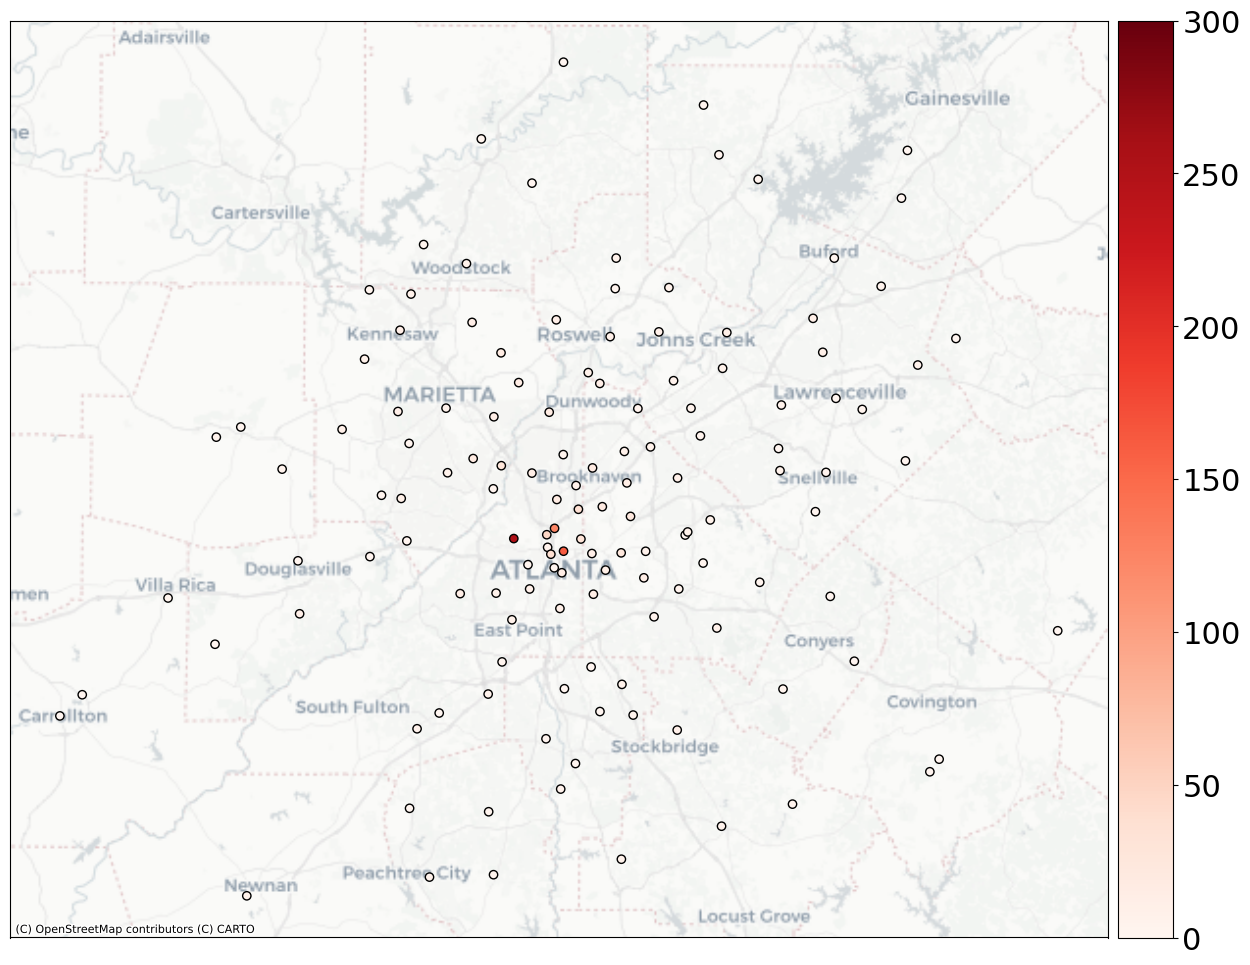

In [93]:
import contextily as cx
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

norm = colors.Normalize(vmin=0, vmax=300)

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

ax = gdf_wm.plot(
    column="count",
    legend=True,
    norm=norm,
    cmap='Reds',
    cax=cax,
    ax=ax,
    edgecolor= "black"
)

cx.add_basemap(
    ax, 
    source=cx.providers.CartoDB.Positron
)

ax.set_xticks([], [])
ax.set_yticks([], [])

plt.show()